<a href="https://colab.research.google.com/github/ninja-marduk/ml_precipitation_prediction/blob/feature%2Fpreprocessing-techniques/notebooks/preprocessing_techniques_parallel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configuración para ejecución local y en Google Colab
Este notebook está diseñado para ejecutarse tanto en un entorno local como en Google Colab. A continuación, se incluyen las configuraciones necesarias para ambos entornos.

In [ ]:
# =============================================================================
# 🚀 Pipeline CEEMDAN + TVF-EMD → high/med/low → fusión → NetCDF + gráficos
#    • Paralelizado con joblib + tqdm
#    • Detecta cores y RAM para ajustar n_jobs
#    • Workaround para evitar los resource_tracker errors en macOS
#    • Filtra warnings generales
#    • Overlay del límite de Boyacá en cada mapa
#    • Al final, impresión de head y estadísticas del NetCDF de fusión
# =============================================================================

import os
import sys
import logging
import warnings
from pathlib import Path

# — Suprimir warnings innecesarios —
warnings.filterwarnings("ignore")

# — Workaround para evitar el error “No child processes” de resource_tracker en macOS —
try:
    import multiprocessing.resource_tracker as rt
    rt.ResourceTracker._stop = lambda self: None
    logging.getLogger(__name__).info("🔧 resource_tracker monkey-patched.")
except ImportError:
    pass

# 1) Entorno (Colab vs. local)
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_PATH = Path('/content/drive/MyDrive/ml_precipitation_prediction')
    # instalar solo lo necesario
    !pip install xarray netCDF4 PyEMD emd cartopy EMD-signal psutil
else:
    BASE_PATH = Path.cwd()
    for p in [BASE_PATH, *BASE_PATH.parents]:
        if (p / '.git').exists():
            BASE_PATH = p
            break

print(f"▶️ Usando ruta base: {BASE_PATH}")

# 2) Rutas
model_output_dir = BASE_PATH / 'models' / 'output'
model_output_dir.mkdir(parents=True, exist_ok=True)
data_file        = BASE_PATH / 'data' / 'output' / 'complete_dataset_with_features_with_clusters_elevation_with_windows.nc'
ceemdan_nc       = model_output_dir / 'features_CEEMDAN.nc'
tvfemd_nc        = model_output_dir / 'features_TVFEMD.nc'
fusion_nc        = model_output_dir / 'features_fusion_branches.nc'
boyaca_shp       = BASE_PATH / 'data' / 'input' / 'shapes' / 'MGN_Departamento.shp'

# 3) Logger
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")
logger = logging.getLogger(__name__)

# 4) Librerías de proceso
import xarray as xr
import numpy as np
from PyEMD import CEEMDAN
from emd import sift
from joblib import Parallel, delayed, cpu_count
from tqdm.auto import tqdm
import psutil

# Para lectura de shapefile
import geopandas as gpd

# Para plots
import matplotlib.pyplot as plt
import cartopy.crs  as ccrs
import cartopy.feature as cfeature

# -----------------------------------------------------------------------------
# 5) Detectar n_jobs según cores y RAM
# -----------------------------------------------------------------------------
total_cores  = cpu_count()
avail_ram_gb = psutil.virtual_memory().available / (1024**3)
if avail_ram_gb < 2:
    n_jobs = 1
elif avail_ram_gb < 8:
    n_jobs = max(1, total_cores // 2)
else:
    n_jobs = max(1, total_cores - 1)

logger.info(f"🔧 Paralelismo: usando n_jobs={n_jobs} (cores={total_cores}, RAM libre≈{avail_ram_gb:.1f}GB)")

# -----------------------------------------------------------------------------
# 6) Función paralela para generar IMFs y guardarlos en un NetCDF
# -----------------------------------------------------------------------------
def generate_imf_netcdf_parallel(method: str, monthly: xr.DataArray, out_path: Path):
    logger.info(f"▶️ Iniciando descomposición {method} en paralelo…")
    ce = CEEMDAN()
    lats, lons = monthly.latitude.values, monthly.longitude.values
    T = monthly.sizes['time']

    def _process_point(i, j, lat, lon):
        ts = monthly.sel(latitude=lat, longitude=lon).values.astype(float)
        if np.all(np.isnan(ts)) or np.all(ts == 0):
            return None
        try:
            raw = ce.ceemdan(ts) if method == 'CEEMDAN' else sift.sift(ts, max_imfs=8)
            arr = np.array(raw)
            if arr.ndim == 2 and arr.shape[0] == T and arr.shape[1] != T:
                arr = arr.T
            assert arr.ndim == 2 and arr.shape[1] == T
            return (i, j, arr)
        except Exception:
            logger.warning(f"⚠️ {method} falló en ({lat:.3f},{lon:.3f})", exc_info=True)
            return None

    tasks = [(i, j, lat, lon)
             for i, lat in enumerate(lats)
             for j, lon in enumerate(lons)]

    results = Parallel(n_jobs=n_jobs, verbose=5)(
        delayed(_process_point)(i, j, lat, lon) for i, j, lat, lon in tasks
    )

    imf_dict = {}
    for res in tqdm(results, desc=f"Assembling IMFs {method}"):
        if res is None:
            continue
        i, j, arr = res
        for k in range(arr.shape[0]):
            imf_dict.setdefault(k+1, np.zeros((T, len(lats), len(lons)), dtype=float))
            imf_dict[k+1][:, i, j] = arr[k]

    if not imf_dict:
        raise RuntimeError(f"No se generó ninguna IMF para {method}")

    data_vars = {
        f"imf_{k}": (("time", "latitude", "longitude"), v)
        for k, v in imf_dict.items()
    }
    ds_out = xr.Dataset(data_vars,
                        coords={"time": monthly.time.values,
                                "latitude": lats,
                                "longitude": lons})
    ds_out.to_netcdf(out_path)
    logger.info(f"💾 Guardado NetCDF IMFs {method}: {out_path.name}")

# -----------------------------------------------------------------------------
# 7) Asegurar NetCDFs de CEEMDAN y TVF-EMD
# -----------------------------------------------------------------------------
try:
    ds0    = xr.open_dataset(data_file)
    precip = ds0['total_precipitation']
    difs   = np.diff(precip.time.values) / np.timedelta64(1, 'D')
    monthly= (precip if np.median(difs) > 2 else precip.resample(time='1M').sum())\
                .load().fillna(0)

    for method, out_path in [('CEEMDAN', ceemdan_nc), ('TVF-EMD', tvfemd_nc)]:
        if out_path.exists():
            logger.info(f"⏩ {out_path.name} ya existe. Omitiendo {method}.")
        else:
            generate_imf_netcdf_parallel(method, monthly, out_path)

except Exception:
    logger.exception("❌ Error generando NetCDFs de IMFs.")

# -----------------------------------------------------------------------------
# 8) Cargar los datasets resultantes
# -----------------------------------------------------------------------------
try:
    ds_C = xr.open_dataset(ceemdan_nc)
    ds_T = xr.open_dataset(tvfemd_nc)
except Exception:
    logger.exception("❌ No se pudieron cargar los NetCDF de IMFs.")
    sys.exit(1)

# -----------------------------------------------------------------------------
# 9) Agrupar en ramas high/medium/low por método
# -----------------------------------------------------------------------------
def make_branches(ds: xr.Dataset, prefix: str):
    ivars = sorted(ds.data_vars, key=lambda v: int(v.split('_')[1]))
    return {
        f"{prefix}_high":   sum(ds[v]   for v in ivars[:2]),
        f"{prefix}_medium": sum(ds[v]   for v in ivars[2:4]),
        f"{prefix}_low":    sum(ds[v]   for v in ivars[4:]),
    }

br_C = make_branches(ds_C, 'CEEMDAN')
br_T = make_branches(ds_T, 'TVFEMD')

# -----------------------------------------------------------------------------
# 10) Fusión lineal α=0.5
# -----------------------------------------------------------------------------
alpha = 0.5
br_F = {
    f"FUSION_{lvl}": alpha*br_C[f"CEEMDAN_{lvl}"] + (1-alpha)*br_T[f"TVFEMD_{lvl}"]
    for lvl in ['high','medium','low']
}

# -----------------------------------------------------------------------------
# 11) Construir y guardar NetCDF final de ramas
# -----------------------------------------------------------------------------
try:
    ds_final = xr.Dataset({**br_C, **br_T, **br_F}, coords=ds_C.coords)
    ds_final.to_netcdf(fusion_nc)
    logger.info(f"💾 NetCDF final guardado: {fusion_nc.name}")
except Exception:
    logger.exception("❌ Error guardando NetCDF final de fusión.")

# -----------------------------------------------------------------------------
# 12) Leer shapefile de Boyacá
# -----------------------------------------------------------------------------
shp_dep = gpd.read_file(boyaca_shp)
geoms   = shp_dep.geometry.values

# -----------------------------------------------------------------------------
# 13) Función de plot para mapas de IMFs y ramas (con overlay Boyacá y colormaps distintos)
# -----------------------------------------------------------------------------
def plot_imfs(ds: xr.Dataset, title: str, cmap: str):
    t0   = ds.time.values[-1]
    date = np.datetime_as_string(t0, unit='M')
    vars_ = list(ds.data_vars)
    n    = len(vars_)
    fig, axs = plt.subplots(
        1, n, figsize=(5*n, 4),
        subplot_kw={'projection': ccrs.PlateCarree()}
    )
    if n == 1:
        axs = [axs]
    for ax, var in zip(axs, vars_):
        arr = ds[var].sel(time=t0)
        mesh = ax.pcolormesh(
            ds.longitude, ds.latitude, arr,
            cmap=cmap, shading='nearest',
            transform=ccrs.PlateCarree()
        )
        ax.coastlines()
        ax.add_feature(cfeature.LAND, facecolor='lightgray')
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        # overlay Boyacá
        ax.add_geometries(geoms, crs=ccrs.PlateCarree(),
                          edgecolor='black', facecolor='none', linewidth=1.5)
        ax.set_title(f"{title}\n{var}\n{date}", fontsize=10)
        cbar = fig.colorbar(mesh, ax=ax, orientation='vertical', pad=0.02)
        cbar.set_label(var, fontsize=8)
    plt.tight_layout()
    out = model_output_dir / f"{title.replace('+','')}_branches_{date}.png"
    fig.savefig(out, dpi=150)
    plt.show()
    logger.info(f"💾 Mapa {title} guardado: {out.name}")

# -----------------------------------------------------------------------------
# 14) Dibujar CEEMDAN, TVF-EMD y FUSION con colormaps específicos
# -----------------------------------------------------------------------------
plot_imfs(ds_C,     "CEEMDAN", cmap='Blues')
plot_imfs(ds_T,     "TVF-EMD", cmap='Reds')
plot_imfs(ds_final, "FUSION",  cmap='Greens')

# -----------------------------------------------------------------------------
# 15) Mostrar head y estadísticas del dataset de fusión
# -----------------------------------------------------------------------------
print("\n--- Head de ds_final ---")
print(ds_final.to_dataframe().head(10))

print("\n--- Estadísticas descriptivas de ds_final ---")
print(ds_final.to_dataframe().describe())

print("\n✅ Proceso completo con gráficos, trazabilidad y paralelo.")


In [ ]:
# %% [markdown]
# # 🌍 Dataset Combination and Processing Pipeline
# 
# Este notebook combina el dataset principal con las características IMF de CEEMDAN y TVFEMD,
# homogeniza las resoluciones espaciales y guarda el resultado final.
# 
# ## 📋 Proceso:
# 1. **Configuración inicial** - Logging y rutas
# 2. **Carga de datasets** - Dataset principal + IMF CEEMDAN + IMF TVFEMD
# 3. **Homogenización** - Resoluciones espaciales consistentes
# 4. **Procesamiento** - Renombrado de variables IMF
# 5. **Combinación** - Merge de todos los datasets
# 6. **Guardado** - Dataset final con compresión optimizada

# %% [markdown]
# ## 1. 🛠️ Configuración Inicial e Importaciones

# %%
import sys
from typing import Dict
import time
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
import xarray as xr

print("📦 Librerías importadas exitosamente")

# %% [markdown]
# ## 2. 🐛 Sistema de Logging Personalizado

# %%
# 🛡️ SISTEMA DE LOGGING SEGURO
_logging_in_progress = set()
import builtins

def info_print(*args, **kwargs):
    """Print para información general con número de línea - protegido contra recursión"""
    frame_id = id(sys._getframe(1)) if sys._getframe else None
    if frame_id in _logging_in_progress:
        builtins.print("ℹ️ ", *args, **kwargs)
        return
    try:
        if frame_id:
            _logging_in_progress.add(frame_id)
        timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        frame = sys._getframe(1)
        line_number = frame.f_lineno
        builtins.print(f"ℹ️  [{timestamp}] [L{line_number}]", *args, **kwargs)
    except:
        builtins.print("ℹ️ ", *args, **kwargs)
    finally:
        if frame_id and frame_id in _logging_in_progress:
            _logging_in_progress.discard(frame_id)

def error_print(*args, **kwargs):
    """Print para errores con número de línea - protegido contra recursión"""
    frame_id = id(sys._getframe(1)) if sys._getframe else None
    if frame_id in _logging_in_progress:
        builtins.print("❌", *args, **kwargs)
        return
    try:
        if frame_id:
            _logging_in_progress.add(frame_id)
        timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        frame = sys._getframe(1)
        line_number = frame.f_lineno
        builtins.print(f"❌ [{timestamp}] [L{line_number}]", *args, **kwargs)
    except:
        builtins.print("❌", *args, **kwargs)
    finally:
        if frame_id and frame_id in _logging_in_progress:
            _logging_in_progress.discard(frame_id)

def success_print(*args, **kwargs):
    """Print para éxitos con número de línea - protegido contra recursión"""
    frame_id = id(sys._getframe(1)) if sys._getframe else None
    if frame_id in _logging_in_progress:
        builtins.print("✅", *args, **kwargs)
        return
    try:
        if frame_id:
            _logging_in_progress.add(frame_id)
        timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        frame = sys._getframe(1)
        line_number = frame.f_lineno
        builtins.print(f"✅ [{timestamp}] [L{line_number}]", *args, **kwargs)
    except:
        builtins.print("✅", *args, **kwargs)
    finally:
        if frame_id and frame_id in _logging_in_progress:
            _logging_in_progress.discard(frame_id)

def warning_print(*args, **kwargs):
    """Print para advertencias con número de línea - protegido contra recursión"""
    frame_id = id(sys._getframe(1)) if sys._getframe else None
    if frame_id in _logging_in_progress:
        builtins.print("⚠️ ", *args, **kwargs)
        return
    try:
        if frame_id:
            _logging_in_progress.add(frame_id)
        timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        frame = sys._getframe(1)
        line_number = frame.f_lineno
        builtins.print(f"⚠️  [{timestamp}] [L{line_number}]", *args, **kwargs)
    except:
        builtins.print("⚠️ ", *args, **kwargs)
    finally:
        if frame_id and frame_id in _logging_in_progress:
            _logging_in_progress.discard(frame_id)

print("🐛 SISTEMA DE LOGGING SEGURO ACTIVADO")
print("   Usa info_print(), error_print(), success_print(), warning_print()")
print("   print() regular funciona normalmente")

# %% [markdown]
# ## 3. 📁 Configuración de Rutas del Proyecto

# %%
# Detectar si estamos en Google Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    info_print("🔧 Detectado entorno Google Colab")
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    BASE_PATH = Path('/content/drive/MyDrive/ml_precipitation_prediction')
    
    # Instalar dependencias necesarias en Colab
    info_print("📦 Instalando dependencias en Colab...")
    !pip install -q xarray netCDF4 optuna matplotlib seaborn lightgbm xgboost scikit-learn
    success_print("✅ Dependencias instaladas")
else:
    info_print("🔧 Detectado entorno local")
    BASE_PATH = Path.cwd()
    # Buscar el directorio raíz del proyecto
    for p in [BASE_PATH, *BASE_PATH.parents]:
        if (p / '.git').exists():
            BASE_PATH = p
            break

info_print(f'📂 BASE_PATH = {BASE_PATH}')

# Configurar todos los directorios necesarios
DATA_DIR = BASE_PATH / 'data' / 'output'
MODEL_OUTPUT_DIR = BASE_PATH / 'models' / 'output'
MODEL_DIR = BASE_PATH / 'models' / 'output' / 'trained_models'
IMAGE_DIR = MODEL_DIR / 'images'

# Crear directorios si no existen
MODEL_DIR.mkdir(parents=True, exist_ok=True)
IMAGE_DIR.mkdir(exist_ok=True)

# Rutas de archivos
IMF_CEEMDAN = MODEL_OUTPUT_DIR / 'features_CEEMDAN.nc'
IMF_TVFEMD = MODEL_OUTPUT_DIR / 'features_TVFEMD.nc'
FULL_NC = DATA_DIR / 'complete_dataset_with_features_with_clusters_elevation_with_windows.nc'
FULL_IMFS_NC = DATA_DIR / 'complete_dataset_with_features_with_clusters_elevation_windows_with_imfs.nc'

# Mostrar todas las rutas configuradas
info_print('📁 Rutas del proyecto configuradas:')
info_print(f'   📂 BASE_PATH: {BASE_PATH}')
info_print(f'   📂 DATA_DIR: {DATA_DIR}')
info_print(f'   📂 MODEL_OUTPUT_DIR: {MODEL_OUTPUT_DIR}')
info_print(f'   📂 MODEL_DIR: {MODEL_DIR}')
info_print(f'   📂 IMAGE_DIR: {IMAGE_DIR}')

status_ceemdan = "✅" if IMF_CEEMDAN.exists() else "❌"
status_tvfemd = "✅" if IMF_TVFEMD.exists() else "❌"
status_full = "✅" if FULL_NC.exists() else "❌"
status_output = "📂" if not FULL_IMFS_NC.exists() else "✅"

info_print(f'   {status_ceemdan} IMF_CEEMDAN: {IMF_CEEMDAN}')
info_print(f'   {status_tvfemd} IMF_TVFEMD: {IMF_TVFEMD}')
info_print(f'   {status_full} FULL_NC: {FULL_NC}')
info_print(f'   {status_output} FULL_IMFS_NC: {FULL_IMFS_NC}')

# %% [markdown]
# ## 4. 📥 Carga de Datasets

# %%
info_print("📥 Iniciando carga de datasets...")

try:
    # Dataset principal
    info_print("🔄 Cargando dataset principal...")
    if not FULL_NC.exists():
        error_print(f"❌ No se encontró el archivo: {FULL_NC}")
        raise FileNotFoundError(f"Dataset principal no encontrado: {FULL_NC}")
    
    ds_full = xr.open_dataset(FULL_NC)
    success_print(f"✅ Dataset principal cargado: {len(ds_full.data_vars)} variables, dimensiones: {dict(ds_full.dims)}")
    
    # Dataset IMF CEEMDAN
    info_print("🔄 Cargando dataset IMF CEEMDAN...")
    if not IMF_CEEMDAN.exists():
        error_print(f"❌ No se encontró el archivo: {IMF_CEEMDAN}")
        raise FileNotFoundError(f"Dataset IMF CEEMDAN no encontrado: {IMF_CEEMDAN}")
    
    ds_imf_ceemdan = xr.open_dataset(IMF_CEEMDAN)
    success_print(f"✅ Dataset IMF CEEMDAN cargado: {len(ds_imf_ceemdan.data_vars)} variables, dimensiones: {dict(ds_imf_ceemdan.dims)}")
    
    # Dataset IMF TVFEMD
    info_print("🔄 Cargando dataset IMF TVFEMD...")
    if not IMF_TVFEMD.exists():
        error_print(f"❌ No se encontró el archivo: {IMF_TVFEMD}")
        raise FileNotFoundError(f"Dataset IMF TVFEMD no encontrado: {IMF_TVFEMD}")
    
    ds_imf_tvfemd = xr.open_dataset(IMF_TVFEMD)
    success_print(f"✅ Dataset IMF TVFEMD cargado: {len(ds_imf_tvfemd.data_vars)} variables, dimensiones: {dict(ds_imf_tvfemd.dims)}")
    
    success_print("🎉 Todos los datasets cargados exitosamente!")
    
except FileNotFoundError as e:
    error_print(f"❌ Error de archivo: {e}")
    raise
except Exception as e:
    error_print(f"❌ Error inesperado al cargar datasets: {e}")
    raise

# %% [markdown]
# ## 5. 🌍 Homogenización de Resoluciones Espaciales

# %%
info_print("🌍 Iniciando homogenización de resoluciones espaciales...")

# Homogenizar CEEMDAN
info_print(f"🌍 Interpolando dataset CEEMDAN a resolución objetivo (método: linear)...")

# Obtener coordenadas espaciales del dataset objetivo
target_lat = ds_full.latitude.values if 'latitude' in ds_full.coords else ds_full.lat.values
target_lon = ds_full.longitude.values if 'longitude' in ds_full.coords else ds_full.lon.values

# Calcular puntos espaciales originales y objetivo para CEEMDAN
if 'latitude' in ds_imf_ceemdan.coords and 'longitude' in ds_imf_ceemdan.coords:
    orig_spatial_points_ceemdan = len(ds_imf_ceemdan.latitude) * len(ds_imf_ceemdan.longitude)
    coord_names_ceemdan = ('latitude', 'longitude')
else:
    orig_spatial_points_ceemdan = len(ds_imf_ceemdan.lat) * len(ds_imf_ceemdan.lon)
    coord_names_ceemdan = ('lat', 'lon')

target_spatial_points = len(target_lat) * len(target_lon)

info_print(f"   📊 CEEMDAN - Resolución original: {orig_spatial_points_ceemdan} puntos espaciales ({len(ds_imf_ceemdan[coord_names_ceemdan[0]])} x {len(ds_imf_ceemdan[coord_names_ceemdan[1]])})")
info_print(f"   🎯 CEEMDAN - Resolución objetivo: {target_spatial_points} puntos espaciales ({len(target_lat)} x {len(target_lon)})")

# Verificar si la interpolación es necesaria para CEEMDAN
if orig_spatial_points_ceemdan == target_spatial_points:
    info_print("   ✅ CEEMDAN - Las resoluciones ya coinciden, no se requiere interpolación")
else:
    # Realizar interpolación CEEMDAN
    info_print(f"   🔄 CEEMDAN - Interpolando {orig_spatial_points_ceemdan} → {target_spatial_points} puntos...")
    
    if coord_names_ceemdan == ('latitude', 'longitude'):
        ds_imf_ceemdan = ds_imf_ceemdan.interp(
            latitude=target_lat,
            longitude=target_lon,
            method='linear'
        )
    else:
        ds_imf_ceemdan = ds_imf_ceemdan.interp(
            lat=target_lat,
            lon=target_lon,
            method='linear'
        )
    
    success_print(f"   ✅ CEEMDAN - Interpolación completada: {orig_spatial_points_ceemdan} → {target_spatial_points} puntos")

# Homogenizar TVFEMD
info_print(f"🌍 Interpolando dataset TVFEMD a resolución objetivo (método: linear)...")

# Calcular puntos espaciales originales y objetivo para TVFEMD
if 'latitude' in ds_imf_tvfemd.coords and 'longitude' in ds_imf_tvfemd.coords:
    orig_spatial_points_tvfemd = len(ds_imf_tvfemd.latitude) * len(ds_imf_tvfemd.longitude)
    coord_names_tvfemd = ('latitude', 'longitude')
else:
    orig_spatial_points_tvfemd = len(ds_imf_tvfemd.lat) * len(ds_imf_tvfemd.lon)
    coord_names_tvfemd = ('lat', 'lon')

info_print(f"   📊 TVFEMD - Resolución original: {orig_spatial_points_tvfemd} puntos espaciales ({len(ds_imf_tvfemd[coord_names_tvfemd[0]])} x {len(ds_imf_tvfemd[coord_names_tvfemd[1]])})")
info_print(f"   🎯 TVFEMD - Resolución objetivo: {target_spatial_points} puntos espaciales ({len(target_lat)} x {len(target_lon)})")

# Verificar si la interpolación es necesaria para TVFEMD
if orig_spatial_points_tvfemd == target_spatial_points:
    info_print("   ✅ TVFEMD - Las resoluciones ya coinciden, no se requiere interpolación")
else:
    # Realizar interpolación TVFEMD
    info_print(f"   🔄 TVFEMD - Interpolando {orig_spatial_points_tvfemd} → {target_spatial_points} puntos...")
    
    if coord_names_tvfemd == ('latitude', 'longitude'):
        ds_imf_tvfemd = ds_imf_tvfemd.interp(
            latitude=target_lat,
            longitude=target_lon,
            method='linear'
        )
    else:
        ds_imf_tvfemd = ds_imf_tvfemd.interp(
            lat=target_lat,
            lon=target_lon,
            method='linear'
        )
    
    success_print(f"   ✅ TVFEMD - Interpolación completada: {orig_spatial_points_tvfemd} → {target_spatial_points} puntos")

success_print("✅ Todas las resoluciones espaciales homogeneizadas!")

# %% [markdown]
# ## 6. 📝 Renombrado de Variables IMF

# %%
info_print("📝 Iniciando renombrado de variables IMF...")

# Mostrar variables originales
info_print("🔍 Variables originales en datasets IMF:")
info_print(f"   CEEMDAN: {list(ds_imf_ceemdan.data_vars.keys())}")
info_print(f"   TVFEMD: {list(ds_imf_tvfemd.data_vars.keys())}")

# Renombrar variables CEEMDAN
info_print(f"📝 Renombrando variables IMF para método: CEEMDAN")

# Buscar variables que empiecen con 'imf_' en CEEMDAN
imf_variables_ceemdan = [var for var in ds_imf_ceemdan.data_vars.keys() if var.startswith('imf_')]

if not imf_variables_ceemdan:
    warning_print(f"⚠️ No se encontraron variables IMF en el dataset CEEMDAN")
else:
    info_print(f"   🔍 CEEMDAN - Encontradas {len(imf_variables_ceemdan)} variables IMF: {imf_variables_ceemdan}")
    
    # Crear diccionario con variables renombradas CEEMDAN
    renamed_data_vars_ceemdan = {}
    
    # Mantener variables que no son IMF
    non_imf_vars_ceemdan = [var for var in ds_imf_ceemdan.data_vars if not var.startswith('imf_')]
    for var_name in non_imf_vars_ceemdan:
        renamed_data_vars_ceemdan[var_name] = ds_imf_ceemdan[var_name]
    
    info_print(f"   📋 CEEMDAN - Manteniendo {len(non_imf_vars_ceemdan)} variables no-IMF")
    
    # Renombrar variables IMF CEEMDAN
    renamed_count_ceemdan = 0
    for var_name in sorted(imf_variables_ceemdan):  # Ordenar para mantener secuencia
        try:
            # Extraer número de variable (imf_1 → 1)
            imf_num = var_name.split('_')[1]
            new_name = f"CEEMDAN_imf_{imf_num}"
            renamed_data_vars_ceemdan[new_name] = ds_imf_ceemdan[var_name]
            info_print(f"      ✅ {var_name} → {new_name}")
            renamed_count_ceemdan += 1
        except (IndexError, ValueError) as e:
            warning_print(f"      ⚠️ No se pudo renombrar: {var_name} (error: {e})")
            # Mantener variable original si no se puede renombrar
            renamed_data_vars_ceemdan[var_name] = ds_imf_ceemdan[var_name]
    
    # Crear nuevo Dataset CEEMDAN con variables renombradas
    ds_imf_ceemdan = xr.Dataset(
        renamed_data_vars_ceemdan,
        coords=ds_imf_ceemdan.coords,
        attrs=ds_imf_ceemdan.attrs
    )
    
    success_print(f"📊 CEEMDAN: {renamed_count_ceemdan}/{len(imf_variables_ceemdan)} variables IMF renombradas exitosamente")

# Renombrar variables TVFEMD
info_print(f"📝 Renombrando variables IMF para método: TVFEMD")

# Buscar variables que empiecen con 'imf_' en TVFEMD
imf_variables_tvfemd = [var for var in ds_imf_tvfemd.data_vars.keys() if var.startswith('imf_')]

if not imf_variables_tvfemd:
    warning_print(f"⚠️ No se encontraron variables IMF en el dataset TVFEMD")
else:
    info_print(f"   🔍 TVFEMD - Encontradas {len(imf_variables_tvfemd)} variables IMF: {imf_variables_tvfemd}")
    
    # Crear diccionario con variables renombradas TVFEMD
    renamed_data_vars_tvfemd = {}
    
    # Mantener variables que no son IMF
    non_imf_vars_tvfemd = [var for var in ds_imf_tvfemd.data_vars if not var.startswith('imf_')]
    for var_name in non_imf_vars_tvfemd:
        renamed_data_vars_tvfemd[var_name] = ds_imf_tvfemd[var_name]
    
    info_print(f"   📋 TVFEMD - Manteniendo {len(non_imf_vars_tvfemd)} variables no-IMF")
    
    # Renombrar variables IMF TVFEMD
    renamed_count_tvfemd = 0
    for var_name in sorted(imf_variables_tvfemd):  # Ordenar para mantener secuencia
        try:
            # Extraer número de variable (imf_1 → 1)
            imf_num = var_name.split('_')[1]
            new_name = f"TVFEMD_imf_{imf_num}"
            renamed_data_vars_tvfemd[new_name] = ds_imf_tvfemd[var_name]
            info_print(f"      ✅ {var_name} → {new_name}")
            renamed_count_tvfemd += 1
        except (IndexError, ValueError) as e:
            warning_print(f"      ⚠️ No se pudo renombrar: {var_name} (error: {e})")
            # Mantener variable original si no se puede renombrar
            renamed_data_vars_tvfemd[var_name] = ds_imf_tvfemd[var_name]
    
    # Crear nuevo Dataset TVFEMD con variables renombradas
    ds_imf_tvfemd = xr.Dataset(
        renamed_data_vars_tvfemd,
        coords=ds_imf_tvfemd.coords,
        attrs=ds_imf_tvfemd.attrs
    )
    
    success_print(f"📊 TVFEMD: {renamed_count_tvfemd}/{len(imf_variables_tvfemd)} variables IMF renombradas exitosamente")

# Mostrar variables renombradas
info_print("📝 Variables después del renombrado:")
ceemdan_vars = [var for var in ds_imf_ceemdan.data_vars.keys() if 'CEEMDAN' in var]
tvfemd_vars = [var for var in ds_imf_tvfemd.data_vars.keys() if 'TVFEMD' in var]

info_print(f"   CEEMDAN: {ceemdan_vars}")
info_print(f"   TVFEMD: {tvfemd_vars}")

success_print("✅ Renombrado de variables IMF completado!")

# %% [markdown]
# ## 7. 🔗 Combinación de Datasets

# %%
info_print("🔗 Iniciando combinación de datasets...")

# Mostrar resumen antes de la combinación
info_print("📊 Resumen de datasets a combinar:")
info_print(f"   📈 Dataset principal: {len(ds_full.data_vars)} variables")
info_print(f"   🌊 IMF CEEMDAN: {len(ds_imf_ceemdan.data_vars)} variables")
info_print(f"   🌊 IMF TVFEMD: {len(ds_imf_tvfemd.data_vars)} variables")

total_expected = len(ds_full.data_vars) + len(ds_imf_ceemdan.data_vars) + len(ds_imf_tvfemd.data_vars)
info_print(f"   🎯 Total esperado: {total_expected} variables")

# Verificar dimensiones compatibles
info_print("🔍 Verificando compatibilidad de dimensiones...")
info_print(f"   📈 Dataset principal: {dict(ds_full.dims)}")
info_print(f"   🌊 IMF CEEMDAN: {dict(ds_imf_ceemdan.dims)}")
info_print(f"   🌊 IMF TVFEMD: {dict(ds_imf_tvfemd.dims)}")

try:
    # Combinar datasets usando merge
    info_print("🔄 Ejecutando merge de datasets...")
    ds_combined = xr.merge([ds_full, ds_imf_ceemdan, ds_imf_tvfemd], 
                          compat='override', join='outer')
    
    # Verificar resultado
    actual_vars = len(ds_combined.data_vars)
    success_print(f"✅ Datasets combinados exitosamente!")
    info_print(f"📊 Resultado: {actual_vars} variables totales")
    info_print(f"📊 Dimensiones finales: {dict(ds_combined.dims)}")
    
    # Verificar si todas las variables se combinaron correctamente
    if actual_vars == total_expected:
        success_print("✅ Todas las variables se combinaron correctamente")
    else:
        warning_print(f"⚠️ Discrepancia en número de variables: esperadas {total_expected}, obtenidas {actual_vars}")
    
    # Mostrar ejemplos de variables por tipo
    original_vars = [var for var in ds_combined.data_vars if not ('CEEMDAN' in var or 'TVFEMD' in var)]
    ceemdan_vars_combined = [var for var in ds_combined.data_vars if 'CEEMDAN' in var]
    tvfemd_vars_combined = [var for var in ds_combined.data_vars if 'TVFEMD' in var]
    
    info_print("📋 Composición del dataset combinado:")
    info_print(f"   📈 Variables originales: {len(original_vars)} (ej: {original_vars[:3]}...)")
    info_print(f"   🌊 Variables CEEMDAN: {len(ceemdan_vars_combined)} (ej: {ceemdan_vars_combined[:3]}...)")
    info_print(f"   🌊 Variables TVFEMD: {len(tvfemd_vars_combined)} (ej: {tvfemd_vars_combined[:3]}...)")
    
except Exception as e:
    error_print(f"❌ Error durante la combinación de datasets: {e}")
    raise

# %% [markdown]
# ## 8. 💾 Guardado del Dataset Combinado

# %%
compression_level = 4

info_print(f"💾 Iniciando guardado del dataset combinado...")
info_print(f"   📁 Ruta de destino: {FULL_IMFS_NC}")
info_print(f"   🗜️ Nivel de compresión: {compression_level}")

try:
    # Crear directorio padre si no existe
    FULL_IMFS_NC.parent.mkdir(parents=True, exist_ok=True)
    info_print(f"   📂 Directorio verificado: {FULL_IMFS_NC.parent}")
    
    # Configurar encoding con compresión para todas las variables
    info_print("🔄 Configurando compresión para todas las variables...")
    encoding = {}
    
    # Configuración de compresión más segura y compatible
    for var in ds_combined.data_vars:
        # Verificar el tipo de datos de la variable
        var_dtype = ds_combined[var].dtype
        
        # Configuración básica de compresión
        var_encoding = {
            'zlib': True, 
            'complevel': compression_level
        }
        
        # Solo aplicar shuffle para tipos de datos apropiados
        if var_dtype in ['float32', 'float64', 'int32', 'int64']:
            var_encoding['shuffle'] = True
        
        # No usar fletcher32 para evitar conflictos
        encoding[var] = var_encoding
    
    info_print(f"   ✅ Configuración de compresión aplicada a {len(encoding)} variables")
    
    # Mostrar información del dataset antes del guardado
    info_print("📊 Información del dataset a guardar:")
    info_print(f"   📈 Variables: {len(ds_combined.data_vars)}")
    info_print(f"   📊 Dimensiones: {dict(ds_combined.dims)}")
    
    # Estimar tamaño aproximado
    total_size_gb = ds_combined.nbytes / (1024**3)
    info_print(f"   💾 Tamaño estimado sin compresión: {total_size_gb:.2f} GB")
    
    # Guardar dataset con manejo de errores mejorado
    info_print("🔄 Guardando dataset (esto puede tomar varios minutos)...")
    start_time = time.time()
    
    try:
        ds_combined.to_netcdf(
            FULL_IMFS_NC,
            encoding=encoding,
            format='NETCDF4'
        )
        save_success = True
    except RuntimeError as e:
        if "Filter error" in str(e):
            warning_print("⚠️ Error con filtros de compresión, intentando sin compresión...")
            # Intentar guardar sin compresión como respaldo
            ds_combined.to_netcdf(
                FULL_IMFS_NC,
                format='NETCDF4'
            )
            save_success = True
        else:
            raise e
    except Exception as e:
        error_print(f"❌ Error inesperado al guardar: {e}")
        save_success = False
        raise e
    
    save_time = time.time() - start_time
    
    # Verificar que el archivo se guardó correctamente
    if not FULL_IMFS_NC.exists():
        error_print("❌ El archivo no se creó correctamente")
        success = False
    else:
        file_size_gb = FULL_IMFS_NC.stat().st_size / (1024**3)
        compression_ratio = (total_size_gb / file_size_gb) if file_size_gb > 0 else 0
        
        success_print(f"✅ Dataset guardado exitosamente en {save_time:.1f} segundos!")
        
        # Mostrar estadísticas finales
        info_print("📊 ESTADÍSTICAS FINALES:")
        info_print(f"   📁 Archivo: {FULL_IMFS_NC}")
        info_print(f"   📏 Tamaño final: {file_size_gb:.2f} GB")
        info_print(f"   🗜️ Ratio de compresión: {compression_ratio:.1f}x")
        info_print(f"   📈 Variables guardadas: {len(ds_combined.data_vars)}")
except Exception as e:
    error_print(f"❌ Error durante el guardado del dataset: {e}")
    raise

## One-Hot Encoding for Elevation Clusters

One-hot encoding transforms a categorical feature into a set of binary (0 / 1) columns—one column per category.  
For **elevation**, the steps are:

1. **Cluster elevations** into meaningful ranges (e.g., `< 1000 m`, `1000 – 2000 m`, `> 2000 m`).
2. **Create a binary column** for each cluster.
3. For every location, set **1** in the column that matches its cluster and **0** in all others.

### Why use one-hot encoding here?

- **Preserves category information** without imposing an artificial numeric order.  
- **Compatible with most ML algorithms**, which expect numeric inputs.  
- **Improves interpretability**—coefficients or feature importances map directly to specific elevation bands.  

---

### Quick Example (Python + pandas)

```python
import pandas as pd

# Sample data
df = pd.DataFrame({
    "elevation_m": [850, 1420, 2150, 950, 1810]
})

# 1️⃣  Define bins and labels
bins   = [0, 1000, 2000, float("inf")]
labels = ["low_<1000m", "mid_1000-2000m", "high_>2000m"]

# 2️⃣  Assign each observation to a cluster
df["elev_cluster"] = pd.cut(df["elevation_m"], bins=bins, labels=labels, right=False)

# 3️⃣  One-hot encode the cluster column
df_encoded = pd.get_dummies(df, columns=["elev_cluster"])

print(df_encoded)


▶️ Ruta base: /Users/riperez/Conda/anaconda3/envs/precipitation_prediction/github.com/ml_precipitation_prediction


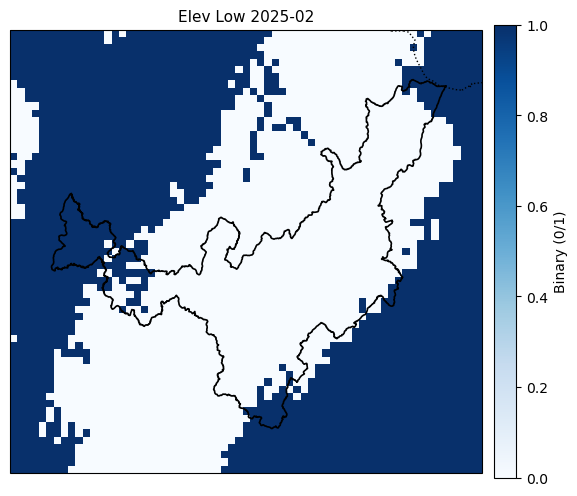

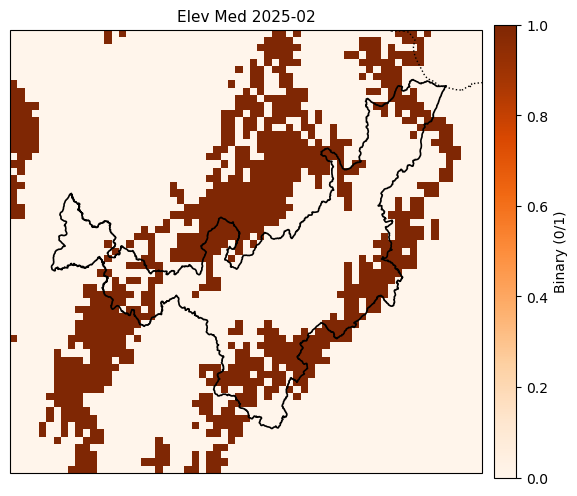

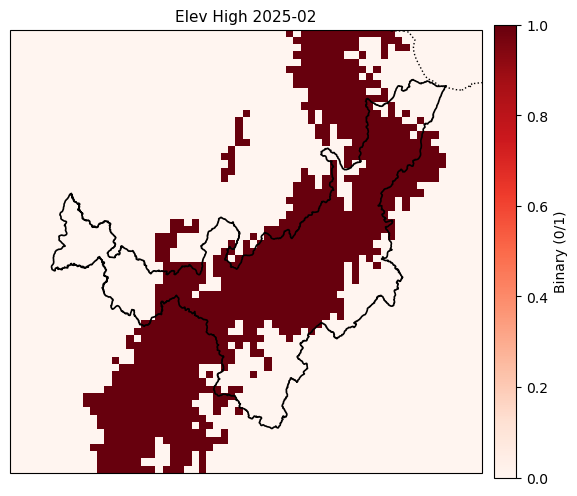


✅ One-hot encoding de elevación completado y visualizado.

✅ Todas las variables han sido expandidas a dimensión espacio-temporal.


In [36]:
# =============================================================================
# 🔄  Re-estructura: One-Hot Encoding de cluster_elevation
#      – Carga dataset con clusters
#      – Genera columnas binarias: cluster_high / cluster_medium / cluster_low
#      – Expande a dimensión temporal (time, latitude, longitude)
#      – Guarda NetCDF actualizado
#      – Grafica mapas de los 3 clusters con overlay del límite de Boyacá
# =============================================================================

import os
import sys
import logging
import warnings
import pandas as pd
from pathlib import Path

warnings.filterwarnings("ignore")

# — Work-around macOS resource_tracker —
try:
    import multiprocessing.resource_tracker as rt
    rt.ResourceTracker._stop = lambda self: None
except ImportError:
    pass

# 1) Entorno (Colab vs local)
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_PATH = Path('/content/drive/MyDrive/ml_precipitation_prediction')
    # instalar lo imprescindible
    !pip install xarray netCDF4 geopandas cartopy psutil
else:
    BASE_PATH = Path.cwd()
    for p in [BASE_PATH, *BASE_PATH.parents]:
        if (p / '.git').exists():
            BASE_PATH = p
            break
print(f"▶️ Ruta base: {BASE_PATH}")

# 2) Rutas
data_file_in   = BASE_PATH / 'data' / 'output' / 'complete_dataset_with_features_with_clusters_elevation_windows_with_imfs.nc'
data_file_out  = BASE_PATH / 'data' / 'output' / 'complete_dataset_with_features_with_clusters_elevation_windows_imfs_with_onehot_elevation.nc'
boyaca_shp     = BASE_PATH / 'data' / 'input' / 'shapes' / 'MGN_Departamento.shp'
fig_dir        = BASE_PATH / 'figures'
fig_dir.mkdir(exist_ok=True, parents=True)

# 3) Logger
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(levelname)s %(message)s",
                    handlers=[logging.StreamHandler(sys.stdout)])
logger = logging.getLogger(__name__)

# 4) Librerías de proceso y visualización
import xarray as xr
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs  as ccrs
import cartopy.feature as cfeature

# -----------------------------------------------------------------------------
# 5) Cargar dataset y verificar variable 'cluster_elevation'
# -----------------------------------------------------------------------------
ds = xr.open_dataset(data_file_in)
if 'cluster_elevation' not in ds:
    raise KeyError("'cluster_elevation' no se encontró en el NetCDF")

cluster = ds['cluster_elevation']  # dims típicas: ('latitude','longitude')

# -----------------------------------------------------------------------------
# 6) Expandir variables espaciales a espacio-temporales
# -----------------------------------------------------------------------------
logger.info("🔄 Expandiendo variables espaciales a dimensión temporal...")

# Obtener la dimensión temporal del dataset
time_coord = ds.time
n_times = len(time_coord)

# Lista de variables espaciales a expandir (excluyendo year y month que ya son temporales)
spatial_vars = ['elevation', 'slope', 'aspect']

for var_name in spatial_vars:
    if var_name in ds:
        var_2d = ds[var_name]
        
        # Verificar que sea 2D (latitude, longitude)
        if len(var_2d.dims) == 2 and 'latitude' in var_2d.dims and 'longitude' in var_2d.dims:
            # Expandir a 3D repitiendo los valores 2D a lo largo del tiempo
            var_values = np.tile(var_2d.values[np.newaxis, :, :], (n_times, 1, 1))
            
            # Crear nuevo DataArray con dimensiones temporales
            ds[var_name] = xr.DataArray(
                var_values.astype(var_2d.dtype),
                coords={'time': time_coord, 'latitude': ds.latitude, 'longitude': ds.longitude},
                dims=['time', 'latitude', 'longitude'],
                attrs=var_2d.attrs  # Preservar atributos originales
            )
            logger.info(f"   ✅ {var_name}: {ds[var_name].dims} - {ds[var_name].shape}")
        else:
            logger.warning(f"   ⚠️ {var_name} no es 2D espacial, se mantiene sin cambios")

# -----------------------------------------------------------------------------
# 7) Expandir year y month de temporal a espacio-temporal
# -----------------------------------------------------------------------------
logger.info("🔄 Expandiendo variables temporales a espacio-temporales...")

# year: de (time,) a (time, latitude, longitude)
if 'year' in ds and len(ds['year'].dims) == 1:
    year_1d = ds['year'].values  # shape: (n_times,)
    n_lat = len(ds.latitude)
    n_lon = len(ds.longitude)
    
    # Expandir a 3D: repetir cada valor de año para todos los píxeles
    year_3d = np.zeros((n_times, n_lat, n_lon), dtype=year_1d.dtype)
    for t in range(n_times):
        year_3d[t, :, :] = year_1d[t]
    
    ds['year'] = xr.DataArray(
        year_3d,
        coords={'time': time_coord, 'latitude': ds.latitude, 'longitude': ds.longitude},
        dims=['time', 'latitude', 'longitude'],
        attrs={'long_name': 'Year', 'units': 'year'}
    )
    logger.info(f"   ✅ year: {ds['year'].dims} - {ds['year'].shape}")

# month: de (time,) a (time, latitude, longitude)
if 'month' in ds and len(ds['month'].dims) == 1:
    month_1d = ds['month'].values  # shape: (n_times,)
    
    # Expandir a 3D: repetir cada valor de mes para todos los píxeles
    month_3d = np.zeros((n_times, n_lat, n_lon), dtype=month_1d.dtype)
    for t in range(n_times):
        month_3d[t, :, :] = month_1d[t]
    
    ds['month'] = xr.DataArray(
        month_3d,
        coords={'time': time_coord, 'latitude': ds.latitude, 'longitude': ds.longitude},
        dims=['time', 'latitude', 'longitude'],
        attrs={'long_name': 'Month', 'units': 'month'}
    )
    logger.info(f"   ✅ month: {ds['month'].dims} - {ds['month'].shape}")

# -----------------------------------------------------------------------------
# 8) One-Hot Encoding con expansión temporal
#     0 → low, 1 → medium, 2 → high   (ajustar si su codificación es distinta)
# -----------------------------------------------------------------------------
clu_raw = ds["cluster_elevation"]

# 1. Convertir a índices 0/1/2 si fuera texto
if clu_raw.dtype.kind in {"U", "O"}:                       # strings/objetos
    map_txt2idx = {"low": 0, "medium": 1, "high": 2}
    clu_idx = xr.apply_ufunc(
        lambda x: np.vectorize(map_txt2idx.get)(x),
        clu_raw,
        vectorize=True,
        dask="allowed",
        keep_attrs=True,
    )
else:                                                      # ya es numérico
    clu_idx = clu_raw

# 2. One-hot espacial: 1 donde corresponda, 0 en lo demás
elev_low_2d  = (clu_idx == 0).astype(np.uint8)   # 1 si low, 0 en otro caso
elev_med_2d  = (clu_idx == 1).astype(np.uint8)   # 1 si medium, 0 en otro caso
elev_high_2d = (clu_idx == 2).astype(np.uint8)   # 1 si high, 0 en otro caso

# 3. Expandir a dimensión temporal para que coincida con otras variables
# Crear arrays 3D repitiendo los valores 2D a lo largo del tiempo
elev_low_values = np.tile(elev_low_2d.values[np.newaxis, :, :], (n_times, 1, 1))
elev_med_values = np.tile(elev_med_2d.values[np.newaxis, :, :], (n_times, 1, 1))
elev_high_values = np.tile(elev_high_2d.values[np.newaxis, :, :], (n_times, 1, 1))

# Crear DataArrays con las coordenadas correctas
ds["elev_low"] = xr.DataArray(
    elev_low_values.astype(np.uint8),
    coords={'time': time_coord, 'latitude': ds.latitude, 'longitude': ds.longitude},
    dims=['time', 'latitude', 'longitude']
)

ds["elev_med"] = xr.DataArray(
    elev_med_values.astype(np.uint8),
    coords={'time': time_coord, 'latitude': ds.latitude, 'longitude': ds.longitude},
    dims=['time', 'latitude', 'longitude']
)

ds["elev_high"] = xr.DataArray(
    elev_high_values.astype(np.uint8),
    coords={'time': time_coord, 'latitude': ds.latitude, 'longitude': ds.longitude},
    dims=['time', 'latitude', 'longitude']
)

logger.info(f"✅ Variables one-hot creadas con dimensiones temporales:")
logger.info(f"   elev_low: {ds['elev_low'].dims} - {ds['elev_low'].shape}")
logger.info(f"   elev_med: {ds['elev_med'].dims} - {ds['elev_med'].shape}")  
logger.info(f"   elev_high: {ds['elev_high'].dims} - {ds['elev_high'].shape}")

# -----------------------------------------------------------------------------
# 9) Expandir cluster_elevation original a espacio-temporal (opcional)
# -----------------------------------------------------------------------------
# Si también quieres mantener cluster_elevation con dimensión temporal
if 'cluster_elevation' in ds and len(ds['cluster_elevation'].dims) == 2:
    clust_2d = ds['cluster_elevation']
    
    # Para strings, necesitamos un approach diferente
    if clust_2d.dtype.kind in {"U", "O"}:
        # Crear array 3D vacío con el tipo de dato correcto
        clust_3d = np.empty((n_times, n_lat, n_lon), dtype=clust_2d.dtype)
        
        # Llenar con los valores 2D repetidos
        for t in range(n_times):
            clust_3d[t, :, :] = clust_2d.values
        
        ds['cluster_elevation'] = xr.DataArray(
            clust_3d,
            coords={'time': time_coord, 'latitude': ds.latitude, 'longitude': ds.longitude},
            dims=['time', 'latitude', 'longitude'],
            attrs=clust_2d.attrs
        )
        logger.info(f"   ✅ cluster_elevation: {ds['cluster_elevation'].dims} - {ds['cluster_elevation'].shape}")

# -----------------------------------------------------------------------------
# 10) Guardar NetCDF actualizado
# -----------------------------------------------------------------------------
ds.to_netcdf(data_file_out)
logger.info(f"💾 Dataset con one-hot encoding guardado en: {data_file_out}")

# -----------------------------------------------------------------------------
# 11) Preparar geometría de Boyacá para overlay
# -----------------------------------------------------------------------------
boyaca_geom = gpd.read_file(boyaca_shp).geometry.values

# -----------------------------------------------------------------------------
# 12) Función de plot para cada cluster binario
# -----------------------------------------------------------------------------
def plot_cluster(var_name: str, cmap: str):
    arr = ds[var_name]
    # Tomar la última fecha si tiene dimensión time, o usar el 2D directamente
    if 'time' in arr.dims:
        arr2d = arr.isel(time=-1)
        date  = np.datetime_as_string(arr.time.values[-1], unit='M')
    else:
        arr2d = arr
        date  = ''
    fig, ax = plt.subplots(
        figsize=(6, 5),
        subplot_kw={'projection': ccrs.PlateCarree()}
    )
    mesh = ax.pcolormesh(
        arr2d.longitude, arr2d.latitude, arr2d,
        cmap=cmap, shading='nearest',
        transform=ccrs.PlateCarree()
    )
    ax.coastlines()
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_geometries(
        boyaca_geom, crs=ccrs.PlateCarree(),
        edgecolor='black', facecolor='none', linewidth=1.2
    )
    ax.set_title(f"{var_name.replace('_', ' ').title()} {date}", fontsize=11)
    cbar = fig.colorbar(mesh, ax=ax, pad=0.02)
    cbar.set_label("Binary (0/1)")
    plt.tight_layout()
    out_png = fig_dir / f"{var_name}_{date or 'static'}.png"
    fig.savefig(out_png, dpi=150)
    plt.show()
    logger.info(f"🗺️ Mapa guardado: {out_png.name}")

# -----------------------------------------------------------------------------
# 13) Dibujar los 3 mapas
# -----------------------------------------------------------------------------
plot_cluster('elev_low',  cmap='Blues')
plot_cluster('elev_med',  cmap='Oranges')
plot_cluster('elev_high', cmap='Reds')

print("\n✅ One-hot encoding de elevación completado y visualizado.")

# =============================================================================
# 14) Validación de cobertura y unicidad de los canales one-hot
# =============================================================================
def validate_onehot(ds, var_names=("elev_low", "elev_med", "elev_high")):
    missing_vars = [v for v in var_names if v not in ds]
    if missing_vars:
        raise ValueError(f"❌ Faltan variables one-hot: {missing_vars}")

    # 1) Shape y NaN check
    for v in var_names:
        arr = ds[v]
        if arr.isnull().any():
            raise ValueError(f"❌ '{v}' contiene valores NaN")
        logger.info(f"✔️ '{v}' sin NaNs y shape={arr.shape}")

    # 2) Suma a 1 en cada posición (para cada tiempo)
    onehot_sum = sum(ds[v] for v in var_names)
    if not ((onehot_sum == 1).all()):
        bad = onehot_sum.where(onehot_sum != 1, drop=True)
        n_bad = bad.count().item()
        raise ValueError(f"❌ Inconsistencia one-hot: {n_bad} celdas no suman 1")

    logger.info(
        "✅ Validación pasada: cada píxel/tiempo tiene exactamente un 1 "
        "y cobertura completa en todas las dimensiones."
    )

# ------------------------------------------------------------------
# Ejecutar la validación justo después de crear los canales one-hot
validate_onehot(ds)

# =============================================================================
# 15) Resumen de variables expandidas
# =============================================================================
logger.info("\n📊 RESUMEN DE VARIABLES ESPACIO-TEMPORALES:")
vars_to_check = ['year', 'month', 'elevation', 'slope', 'aspect', 'cluster_elevation', 
                 'elev_low', 'elev_med', 'elev_high']

for var in vars_to_check:
    if var in ds:
        logger.info(f"   {var:20s}: {str(ds[var].dims):30s} shape={ds[var].shape}")
    else:
        logger.info(f"   {var:20s}: NO ENCONTRADA")

print("\n✅ Todas las variables han sido expandidas a dimensión espacio-temporal.")

In [37]:
# Ruta a tu NetCDF (usa el que corresponda en tu proyecto)
nc_path = data_file_out
ds_load      = xr.open_dataset(nc_path, chunks={})   # chunks={} → perezoso; ajusta si ya cargaste el Dataset

print(ds_load.dims)
print(ds_load.sizes)
print(ds_load.data_vars)
print(ds_load.coords)
print(ds_load.attrs)

FrozenMappingWarningOnValuesAccess({'time': 530, 'latitude': 61, 'longitude': 65})
Frozen({'time': 530, 'latitude': 61, 'longitude': 65})
Data variables:
    total_precipitation        (time, latitude, longitude) float32 8MB dask.array<chunksize=(530, 61, 65), meta=np.ndarray>
    max_daily_precipitation    (time, latitude, longitude) float32 8MB dask.array<chunksize=(530, 61, 65), meta=np.ndarray>
    min_daily_precipitation    (time, latitude, longitude) float32 8MB dask.array<chunksize=(530, 61, 65), meta=np.ndarray>
    daily_precipitation_std    (time, latitude, longitude) float32 8MB dask.array<chunksize=(530, 61, 65), meta=np.ndarray>
    month_sin                  (time, latitude, longitude) float32 8MB dask.array<chunksize=(530, 61, 65), meta=np.ndarray>
    month_cos                  (time, latitude, longitude) float32 8MB dask.array<chunksize=(530, 61, 65), meta=np.ndarray>
    doy_sin                    (time, latitude, longitude) float32 8MB dask.array<chunksize=(530, 61, 